In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_full_coll/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,4.027001e-01,9.860918e-02,3.749753e-01,5.920373e-02,...,1.145965e-02,1.972030e-02,7.959556e-02,1.343719e-01,9.534855e-03,1.751229e-02,6.396949e-02,6.042839e-02,2.191224e-02,4.468485e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,4.523420e-01,2.908001e-01,4.479160e-01,2.284681e-01,...,5.401390e-02,8.011601e-02,1.179346e-01,1.749533e-01,5.258916e-02,8.239552e-02,9.937732e-02,1.003326e-01,8.736962e-02,1.013914e-01
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.438514e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,9.387755e-01,0.000000e+00,9.230769e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.891430e-02,8.847414e-02,0.000000e+00,2.582313e-02
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [5]:
# Samples only rows that have some positive link intensity value.
# This ensures that the integrator and the submitter have collaborated in the ecosystem before.

df = df[df["ln(1 + EcosystemLinkIntensity)"].gt(0)].reset_index(drop=True)

In [6]:
intra_collab_fields = [
    "ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)",
    "ln(1 + IntraProjectLinkIntensity)",
]

df = df.drop(intra_collab_fields, axis=1)

In [7]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [8]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=7.594715268628312


## Model Creation

In [9]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [10]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [11]:
from wmutils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [12]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43random_state=43

random_state=43
random_state=43
random_state=43
metrics={'accuracy': 0.9164963379322092, 'precision': 0.9278757809628813, 'recall': 0.9810092767982903, 'f1': 0.9537030479023537}

Confusion matrix:
[[ 1325  1570]
 [  391 20198]]

Classification report:
              precision    recall  f1-score   support

       False       0.77      0.46      0.57      2895
        True       0.93      0.98      0.95     20589

    accuracy                           0.92     23484
   macro avg       0.85      0.72      0.76     23484
weighted avg       0.91      0.92      0.91     23484

metrics={'accuracy': 0.9199029126213593, 'precision': 0.9310802158602396, 'recall': 0.9819611247769257, 'f1': 0.9558440338975093}

Confusion matrix:
[[ 1244  1507]
 [  374 20359]]

Classification report:
              precision    recall  f1-score   support

       False       0.77      0.45      0.57      2751
        True       0.93      0.98      0.96     20733

    accuracy         

### Control + Intra-project Model

In [13]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45
random_state=45
random_state=45
random_state=45random_state=45

metrics={'accuracy': 0.907639243740419, 'precision': 0.928776113884267, 'recall': 0.9696955074072287, 'f1': 0.9487948251847305}

Confusion matrix:
[[ 1220  1541]
 [  628 20095]]

Classification report:
              precision    recall  f1-score   support

       False       0.66      0.44      0.53      2761
        True       0.93      0.97      0.95     20723

    accuracy                           0.91     23484
   macro avg       0.79      0.71      0.74     23484
weighted avg       0.90      0.91      0.90     23484

metrics={'accuracy': 0.9068301822517458, 'precision': 0.9274673556960273, 'recall': 0.9702659651493942, 'f1': 0.9483840528426516}

Confusion matrix:
[[ 1195  1572]
 [  616 20101]]

Classification report:
              precision    recall  f1-score   support

       False       0.66      0.43      0.52      2767
        True       0.93      0.97      0.95     20717

    accuracy           

### Collaboration and Ecosystem Model

In [14]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

random_state=47random_state=47

random_state=47random_state=47random_state=47


metrics={'accuracy': 0.888605007664793, 'precision': 0.9009914195527498, 'recall': 0.9811667877027355, 'f1': 0.9393714656531009}

Confusion matrix:
[[  602  2227]
 [  389 20266]]

Classification report:
              precision    recall  f1-score   support

       False       0.61      0.21      0.32      2829
        True       0.90      0.98      0.94     20655

    accuracy                           0.89     23484
   macro avg       0.75      0.60      0.63     23484
weighted avg       0.87      0.89      0.86     23484

metrics={'accuracy': 0.8923096576392437, 'precision': 0.9052195968495528, 'recall': 0.980763667920162, 'f1': 0.9414786532454008}

Confusion matrix:
[[  612  2130]
 [  399 20343]]

Classification report:
              precision    recall  f1-score   support

       False       0.61      0.22      0.33      2742
        True       0.91      0.98      0.94     20742

    accuracy           

## Feature Explanation and Evaluation

### Model Creation

In [15]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49
metrics={'accuracy': 0.921865020225676, 'precision': 0.934733957524549, 'recall': 0.9805481027213492, 'f1': 0.9570930857904458}

Confusion matrix:
[[ 1184  1429]
 [  406 20466]]

Classification report:
              precision    recall  f1-score   support

       False       0.74      0.45      0.56      2613
        True       0.93      0.98      0.96     20872

    accuracy                           0.92     23485
   macro avg       0.84      0.72      0.76     23485
weighted avg       0.91      0.92      0.91     23485



### Mean decrease in Impurity

/tmp/ipykernel_1739/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


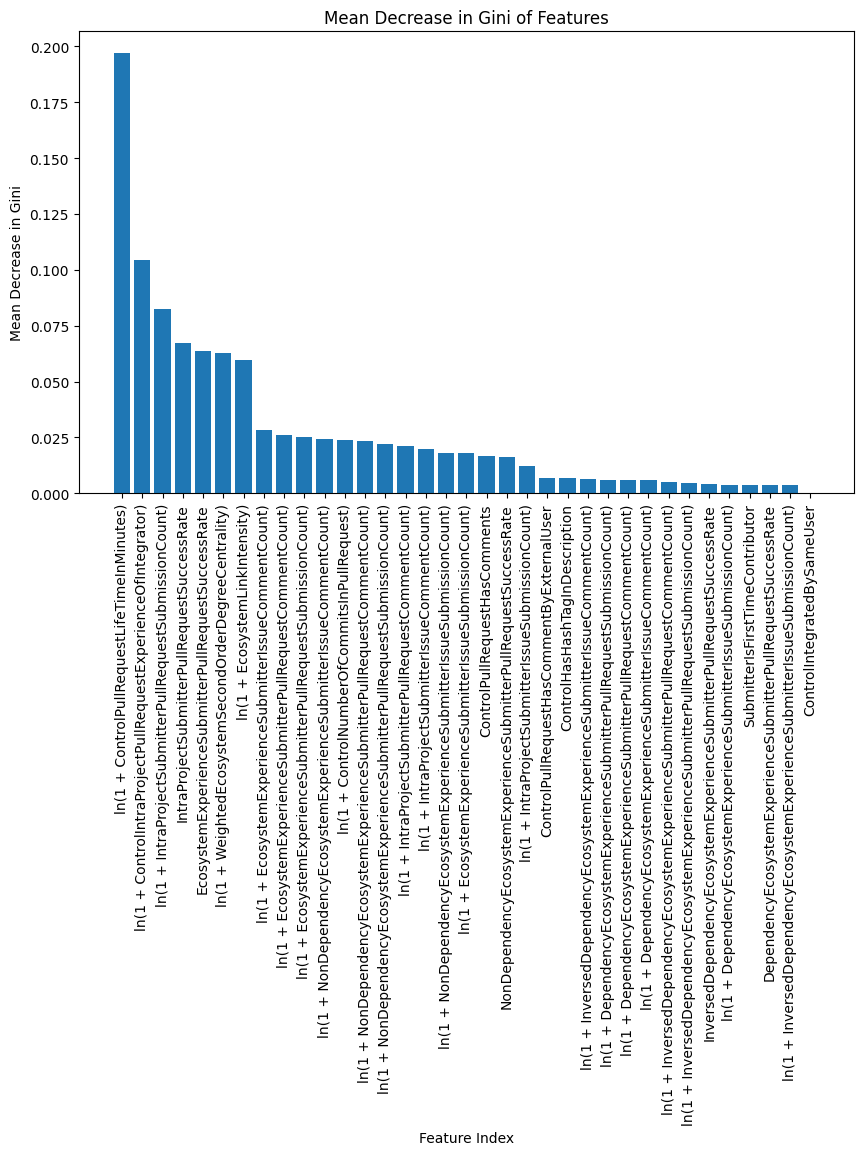

In [16]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [18]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.19689418457423424
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.10440023201714968
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.08268541085660276
IntraProjectSubmitterPullRequestSuccessRate: 0.06715595895677645
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.06380325527373526
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.06291118486329339
ln(1 + EcosystemLinkIntensity): 0.05963597451788715
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.028369319613421373
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.02622769013033387
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.025334884089758435
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.024270904707761883
ln(1 + ControlNumberOfCommitsInPullRequest): 0.023734199065974352
ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount): 0.023341144022568875
ln(1 + NonDependencyE

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [19]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].
random_state=50
random_state=50
random_state=50
random_state=50
random_state=50


metrics={'accuracy': 0.8744677227048203, 'precision': 0.905719759168035, 'recall': 0.9575176005400714, 'f1': 0.9308986920444424}

Confusion matrix:
[[  679  2067]
 [  881 19857]]

Classification report:
              precision    recall  f1-score   support

       False       0.44      0.25      0.32      2746
        True       0.91      0.96      0.93     20738

    accuracy                           0.87     23484
   macro avg       0.67      0.60      0.62     23484
weighted avg       0.85      0.87      0.86     23484

metrics={'accuracy': 0.8707685756866085, 'precision': 0.9028094499680744, 'recall': 0.9563263925793517, 'f1': 0.9287976539589442}

Confusion matrix:
[[  655  2131]
 [  904 19795]]

Classification report:
metrics={'accuracy': 0.8744251405212059, 'precision': 0.9087544549026775, 'recall': 0.9543208099419414, 'f1': 0.9309804105132585}

Confusion matrix:
[[  646  1997]
 [  952 19889]]

Classification report:
              precision    recall  f1-score   support

       

In [20]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.9308986920444424, 0.9287976539589442, 0.9309804105132585, 0.9319920458533162, 0.9319606925596631]
f1_mean=0.9309258989859248, f1_std=0.0011610861727058177

Cluster 'FeatureGroups.Intra':
f1_scores=[0.9388091854975478, 0.9375688578773412, 0.9389649889089621, 0.9393946326843442, 0.9389363700937149]
f1_mean=0.9387348070123821, f1_std=0.0006154593151797841

Cluster 'FeatureGroups.Eco':
f1_scores=[0.9375505768652748, 0.9355826797233955, 0.9365550505518969, 0.9372654403929018, 0.9379054680259499]
f1_mean=0.9369718431118838, f1_std=0.0008241697105422909

Cluster 'FeatureGroups.DEco':
f1_scores=[0.9395450013595577, 0.9375510574566579, 0.9372118900015894, 0.9366691662690027, 0.9386579585912873]
f1_mean=0.9379270147356191, f1_std=0.0010379874431974054

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.9365782716386029, 0.9363752045082712, 0.9374957429901238, 0.9401883546137825, 0.9387024405719595]
f1_mean=0.937868002864548

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [21]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.8836494323843264.
{
    "accuracy": 0.7966787311049606,
    "precision": 0.8884598677542352,
    "recall": 0.8819471061709467,
    "f1": 0.885191507778125
}


In [22]:
import datetime

print(datetime.datetime.now())

2024-03-07 11:28:36.867516
